In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d prasunroy/natural-images

Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile("natural-images.zip", 'r') as zip_ref:
    zip_ref.extractall()  # Extract all files in the current directory


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Set the main data directory
data_dir = '/content/natural_images'

# Define the classes directly from the folders
classes = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [ ]:

def load_images_from_folder(data_dir):
    images = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        # Check if the folder exists
        if os.path.exists(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (32, 32))  # Resizing to 32x32
                    images.append(img)
                    labels.append(idx)  # Assign class index
        else:
            print(f"Folder not found: {class_folder}")
    return np.array(images), np.array(labels)

# Load data
X, y = load_images_from_folder(data_dir)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Output layer for multiclass
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,944 (624.78 KB)

 Trainable params: 159,944 (624.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping]  # Add the early stopping callback here
)


Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3397 - loss: 1.7325 - val_accuracy: 0.7268 - val_loss: 0.7722
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7146 - loss: 0.7867 - val_accuracy: 0.7935 - val_loss: 0.5675
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7932 - loss: 0.5577 - val_accuracy: 0.8514 - val_loss: 0.4126
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8337 - loss: 0.4395 - val_accuracy: 0.8551 - val_loss: 0.3869
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8384 - loss: 0.4224 - val_accuracy: 0.8739 - val_loss: 0.3532
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8719 - loss: 0.3181 - val_accuracy: 0.8674 - val_loss: 0.3339
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8846 - loss: 0.2983 - val_accuracy: 0.8768 - val_loss: 0.3184
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.2614 - val_accuracy: 0

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc:.4f}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9042 - loss: 0.2452
Validation accuracy: 0.9101


In [ ]:
# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print(confusion_matrix(y_true, y_pred_classes))


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       161
           1       0.94      0.95      0.95       201
           2       0.79      0.69      0.74       170
           3       0.66      0.77      0.71       132
           4       0.93      0.94      0.93       170
           5       1.00      0.99      1.00       183
           6       0.95      0.95      0.95       151
           7       1.00      0.97      0.99       212

    accuracy                           0.91      1380
   macro avg       0.90      0.90      0.90      1380
weighted avg       0.91      0.91      0.91      1380

[[155   4   0   1   1   0   0   0]
 [  1 191   3   2   2   0   2   0]
 [  7   3 118  39   3   0   0   0]
 [  1   0  21 101   5   0   4   0]
 [  0   1   4   4 159   0   2   0]
 [  0   0   1   0   0 182   0   0]
 [  1   3   0   2   1   0 144   0]
 [  0   1   2   3   0   0   0 206]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       161
           1       0.94      0.95      0.95       201
           2       0.79      0.69      0.74       170
           3       0.66      0.77      0.71       132
           4       0.93      0.94      0.93       170
           5       1.00      0.99      1.00       183
           6       0.95      0.95      0.95       151
           7       1.00      0.97      0.99       212

    accuracy                           0.91      1380
   macro avg       0.90      0.90      0.90      1380
weighted avg       0.91      0.91      0.91      1380



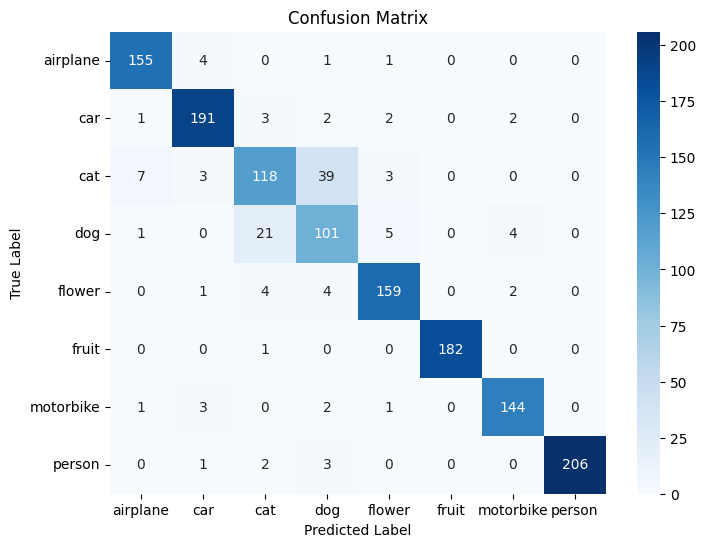

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


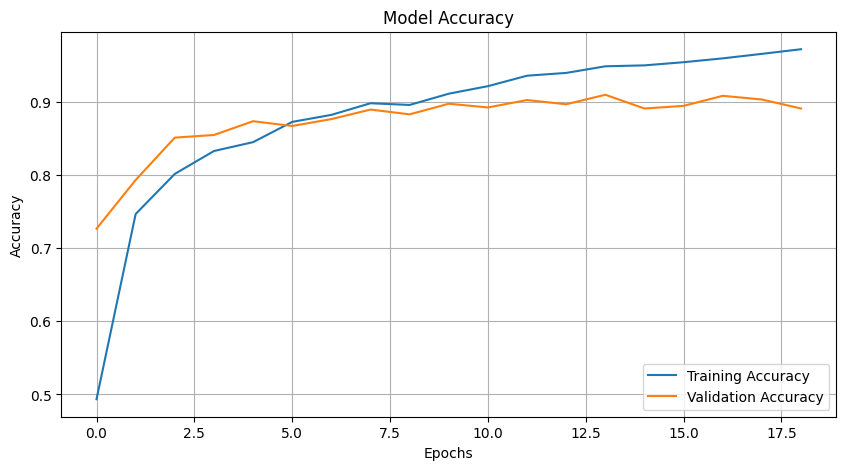

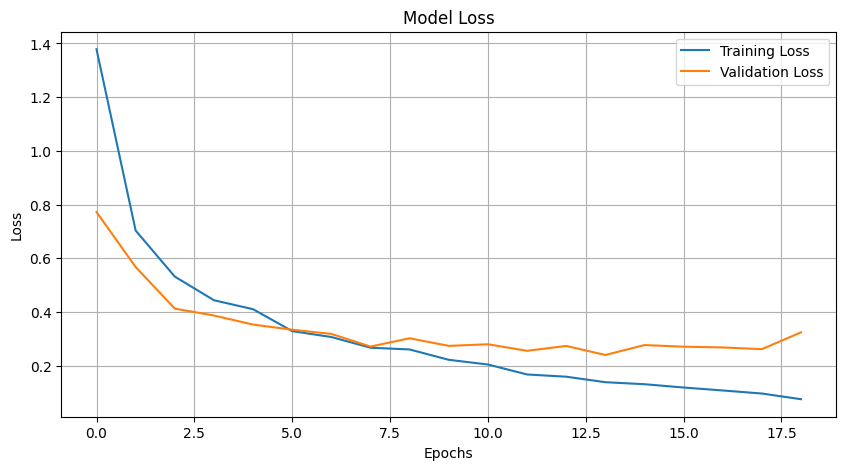

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



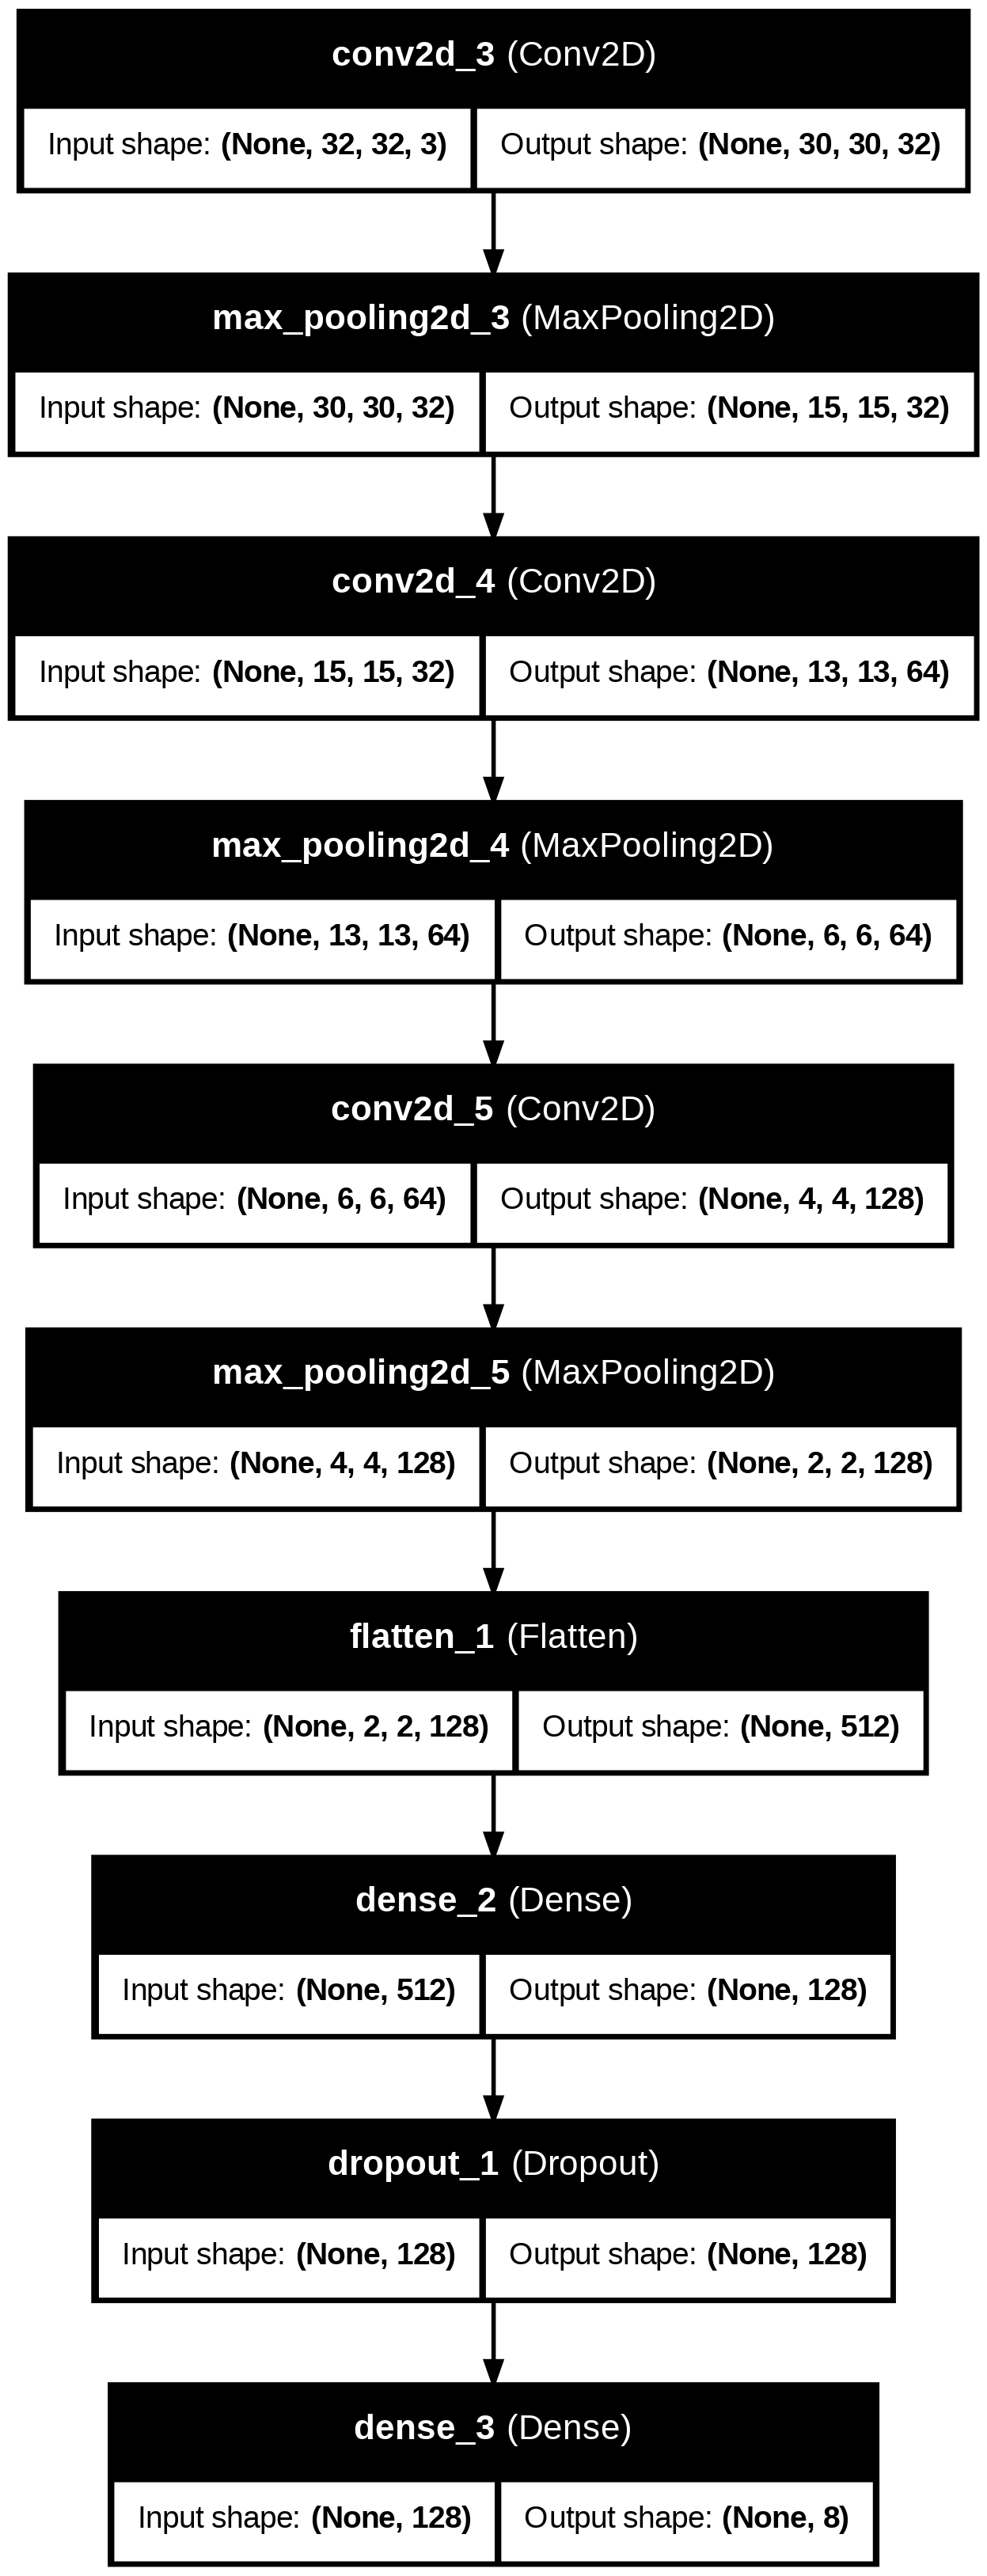

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_diagram.png',show_shapes=True,show_layer_names='True')

### SAMPLE INPUT AND CLASSIFICATION

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
The image is classified as: airplane


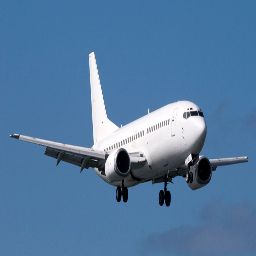

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Function to preprocess the uploaded image
def preprocess_image(image_path, img_size=(32, 32)):
    test_img = cv2.imread(image_path)

    # Resize the image to match the input size expected by the model
    test_img_resized = cv2.resize(test_img, img_size)

    # Normalize the image
    test_img_normalized = test_img_resized / 255.0

    # Reshape the image to the format (1, height, width, channels)
    test_input = test_img_normalized.reshape((1, img_size[0], img_size[1], 3))

    return test_img, test_input

# Function to load and make predictions on a single image
def predict_image(model, image_path, display_size=(256, 256)):
    # Preprocess the uploaded image
    original_img, processed_image = preprocess_image(image_path)

    # Use the model to predict
    prediction = model.predict(processed_image)

    # Get the class label (0 to n-1 for n classes)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Mapping class indices to class names
    class_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
    label = class_names[predicted_label]  # Get the corresponding class name

    # Resize the image for display purposes
    display_img = cv2.resize(original_img, display_size)

    # Display the image and the prediction
    print(f"The image is classified as: {label}")
    cv2_imshow(display_img)  # Show the image with the new display size

# Example usage
image_path = '/content/boeing.jpeg'  # Provide the path of the uploaded image here
predict_image(model, image_path)


## The sample input image entered above has been correctly interpreted as Airplane.